# Data loading and preprocessing
This notebook performs data loading, Merging,EDA,preprocessing and saving cleaned Data. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


#### Load Data

In [2]:
import os
from src.data_processing import load_data

# Step 1: Define the data folder
data_folder = os.path.join(os.getcwd(), "data")

# Step 2: Load all datasets
data = load_data(data_folder)

# Step 3: Preview
for name, df in data.items():
    print(f"{name} shape: {df.shape}")
    display(df.head(2))



Loaded holidays_events.csv — Shape: (350, 6)
Loaded oil.csv — Shape: (1218, 2)
Loaded sample_submission.csv — Shape: (28512, 2)
Loaded stores.csv — Shape: (54, 5)
Loaded test.csv — Shape: (28512, 5)
Loaded train.csv — Shape: (3000888, 6)
Loaded transactions.csv — Shape: (83488, 3)
holidays_events shape: (350, 6)


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False


oil shape: (1218, 2)


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14


sample_submission shape: (28512, 2)


,id,sales
0,3000888,0.0
1,3000889,0.0


stores shape: (54, 5)


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13


test shape: (28512, 5)


,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0


train shape: (3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0


transactions shape: (83488, 3)


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111


### Merging Data

In [4]:
print(data.keys())


dict_keys(['holidays_events', 'oil', 'sample_submission', 'stores', 'test', 'train', 'transactions'])


In [5]:
# Start with train dataset
merged = data['train'].copy()


In [6]:
# Merge stores
merged = merged.merge(data['stores'], on='store_nbr', how='left')

# Merge transactions
merged = merged.merge(data['transactions'], on=['date','store_nbr'], how='left')
merged['transactions'] = merged['transactions'].fillna(0)

# Merge holidays
holidays = data['holidays_events'].copy()
holidays['is_holiday'] = 1
merged = merged.merge(holidays[['date','is_holiday']], on='date', how='left')
merged['is_holiday'] = merged['is_holiday'].fillna(0)

# Merge oil prices
merged = merged.merge(data['oil'], on='date', how='left')
merged['dcoilwtico'] = merged['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')


C:\Users\navya\AppData\Local\Temp\ipykernel_237264\3823584585.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged['dcoilwtico'] = merged['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')


In [7]:
# Check the shape
print("Merged dataset shape:", merged.shape)

# Preview the first few rows
merged.head(5)


Merged dataset shape: (3054348, 13)


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,transactions,is_holiday,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,0.0,1.0,93.14
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,0.0,1.0,93.14
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,0.0,1.0,93.14
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,0.0,1.0,93.14
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,0.0,1.0,93.14



#### Retail Sales Forecasting: Data Merging Overview

- Started with **train** as the base dataset.  
- Merged **store info** (`stores.csv`) → added `city`, `state`, `type`, `cluster`.  
- Merged **transactions** (`transactions.csv`) → added `transactions` column.  
- Merged **holiday info** (`holidays_events.csv`) → added `is_holiday` binary column.  
- Merged **oil prices** (`oil.csv`) → added `dcoilwtico` column.  


**Final Dataset:**
- **Rows**: 3,054,348  
- **Columns**: 13 (`id`, `date`, `store_nbr`, `family`, `sales`, `onpromotion`, `city`, `state`, `type`, `cluster`, `transactions`, `is_holiday`, `dcoilwtico`)  



### EDA and Preprocessing

In [8]:
# Check missing values in each column
missing_values = merged.isnull().sum()
print("Missing values per column:\n", missing_values)


Missing values per column:
 id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
city            0
state           0
type            0
cluster         0
transactions    0
is_holiday      0
dcoilwtico      0
dtype: int64


In [9]:
# Check data types
print(merged.dtypes)


id                int64
date             object
store_nbr         int64
family           object
sales           float64
onpromotion       int64
city             object
state            object
type             object
cluster           int64
transactions    float64
is_holiday      float64
dcoilwtico      float64
dtype: object


In [10]:
# Convert date column to datetime
merged['date'] = pd.to_datetime(merged['date'])

print(merged.dtypes)


id                       int64
date            datetime64[ns]
store_nbr                int64
family                  object
sales                  float64
onpromotion              int64
city                    object
state                   object
type                    object
cluster                  int64
transactions           float64
is_holiday             float64
dcoilwtico             float64
dtype: object


                 id                           date     store_nbr  \
count  3.054348e+06                        3054348  3.054348e+06   
mean   1.504277e+06  2015-04-26 12:11:45.717619200  2.750000e+01   
min    0.000000e+00            2013-01-01 00:00:00  1.000000e+00   
25%    7.546768e+05            2014-03-01 00:00:00  1.400000e+01   
50%    1.507572e+06            2015-04-28 12:00:00  2.750000e+01   
75%    2.255120e+06            2016-06-22 00:00:00  4.100000e+01   
max    3.000887e+06            2017-08-15 00:00:00  5.400000e+01   
std    8.662610e+05                            NaN  1.558579e+01   

              sales   onpromotion       cluster  transactions    is_holiday  \
count  3.054348e+06  3.054348e+06  3.054348e+06  3.054348e+06  3.054348e+06   
mean   3.590209e+02  2.617480e+00  8.481481e+00  1.558656e+03  1.645274e-01   
min    0.000000e+00  0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00  4.000000e+00  9.310000e+02  0.000000

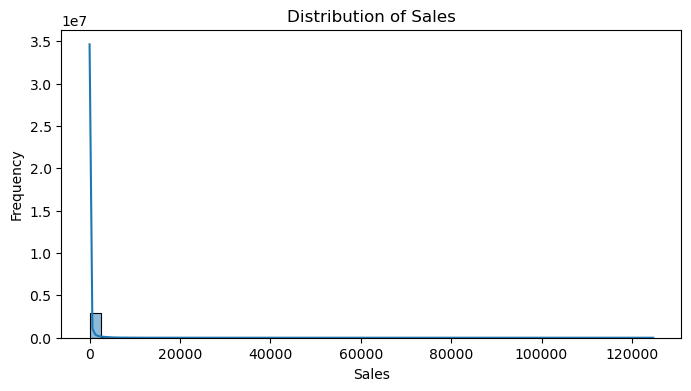

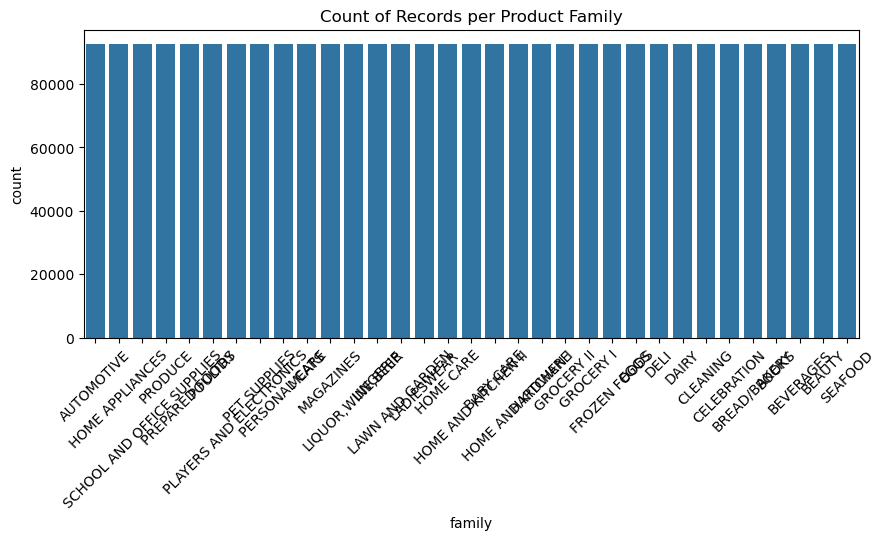

In [11]:
# Summary statistics for numeric columns
print(merged.describe())

# Distribution of sales
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.histplot(merged['sales'], bins=50, kde=True)
plt.title("Distribution of Sales")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

# Count of sales per product family
plt.figure(figsize=(10,4))
sns.countplot(data=merged, x='family', order=merged['family'].value_counts().index)
plt.title("Count of Records per Product Family")
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Handling Skewness
import numpy as np
merged['sales_log'] = np.log1p(merged['sales'])


In [14]:
categorical_cols = ['family', 'type', 'cluster', 'store_nbr', 'city', 'state']
for col in categorical_cols:
    print(f"{col} unique values: {merged[col].nunique()}")


family unique values: 33
type unique values: 5
cluster unique values: 17
store_nbr unique values: 54
city unique values: 22
state unique values: 16


In [16]:

categorical_cols = ['family', 'type', 'cluster', 'store_nbr', 'city', 'state']

# Convert to 'category' type
for col in categorical_cols:
    merged[col] = merged[col].astype('category')


In [23]:
merged.to_csv("data/merged_cleaned.csv", index=False)
print(" Cleaned dataset saved as 'merged_cleaned.csv'")


 Cleaned dataset saved as 'merged_cleaned.csv'


Checked for missing values → none found.

Converted categorical columns (family, store_nbr, city, state, type, cluster) to category.

Handled skewness → applied log transformation on sales to create sales_log.